In [ ]:
import os
from brainnetwork import load_data, preprocess_data, preprocess_spike_data
from brainnetwork import classify_by_timepoints, FI_by_timepoints_v2, FI_by_neuron_count
from brainnetwork import construct_correlation_network, compute_network_metrics_by_class
import matplotlib.pyplot as plt

In [ ]:
base_dir = os.environ.get('USERPROFILE') + "\\OneDrive\\brain\\Micedata"
data_path = base_dir + '\\M77_1031'

In [ ]:
neuron_data, neuron_pos, start_edges, stimulus_data = load_data(data_path)
segments_spi, labels_spi, neuron_pos_spi = preprocess_spike_data(
        neuron_data,
        neuron_pos,
        start_edges,
        stimulus_data,
    )
neuron_data_flo, neuron_pos_flo, start_edges_flo, stimulus_data_flo = load_data(data_path, data_type='fluorescence')
segments_flo, labels_flo, neuron_pos_flo = preprocess_data(
    neuron_data_flo,
    neuron_pos_flo,
    start_edges_flo,
    stimulus_data_flo,
)

原始神经数据形状: (7681, 35896)
使用快速RR筛选算法...
处理 137 个试次, 35896 个神经元
快速RR筛选完成，耗时: 10.19秒
原始神经数据形状: (7681, 35953)
使用快速RR筛选算法...
处理 137 个试次, 35896 个神经元
快速RR筛选完成，耗时: 10.95秒


In [ ]:
# %% 可视化相关函数定义
from tifffile import imread 
import numpy as np
import scipy.stats as stats

def rr_distribution_plot_pretty(neuron_pos, neuron_pos_rr, data_path,
                                x_total_mm=7.0,
                                scalebar_mm=1.0,
                                gamma=1.25,
                                bg_p_low=2,
                                bg_p_high=98):
    """
    优化版 RR neuron distribution plot
    - All neurons: 用密度图(hist2d)避免点重叠
    - RR neurons: 散点+白色描边更清楚
    - 去坐标轴：保留比例尺（X轴总长=7mm）
    - 背景：更柔和对比度 + gamma 压亮度
    """
    from matplotlib.colors import LogNorm
    from matplotlib.patches import Rectangle
    fig, ax = plt.subplots(figsize=(8.5, 7), dpi=200)

    # --- 背景图像 ---
    brain_img = imread(f"{data_path}/whole_brain_3d.tif")
    mid_slice = brain_img[brain_img.shape[0] // 4, :, :].astype(np.float32)

    # normalize to [0,1]
    mid_slice = mid_slice - np.nanmin(mid_slice)
    mid_slice = mid_slice / (np.nanmax(mid_slice) + 1e-8)

    # 温和对比度拉伸（避免过强）
    vmin = np.percentile(mid_slice, bg_p_low)
    vmax = np.percentile(mid_slice, bg_p_high)
    bg = np.clip((mid_slice - vmin) / (vmax - vmin + 1e-8), 0, 1)

    # gamma > 1 会压暗中高亮区域（整体不那么亮、对比不刺）
    if gamma is not None:
        bg = bg ** gamma

    ax.imshow(bg, cmap="gray", interpolation="nearest")

    # =======================
    # All neurons（散点，极轻）
    # =======================
    ax.scatter(
        neuron_pos[1, :],
        neuron_pos[0, :],
        s=10,                    # 非常小
        c="#6B7B61",               # 冷灰
        alpha=0.3,             # 极低透明度
        marker="o",
        linewidths=0,
        rasterized=True,        # 导出 PDF 非常重要
        zorder=2
    )


    # --- RR neurons：散点更醒目 + 描边 ---
    x_rr = neuron_pos_rr[1, :]
    y_rr = neuron_pos_rr[0, :]

    ax.scatter(
        x_rr, y_rr,
        s=40,
        c="#1ada4a",
        alpha=0.9,
        linewidths=0.6,
        edgecolors="#000000",   # 白描边让红点从背景里“跳出来”
        zorder=5
    )

    # --- 去掉坐标轴/网格/边框 ---
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    # --- 比例尺（X轴总长=7mm） ---
    # 像素->mm：整张图宽 bg.shape[1] 像素对应 x_total_mm mm
    px_per_mm = bg.shape[1] / x_total_mm
    bar_px = scalebar_mm * px_per_mm

    # 放在右下角，留一点边距
    pad = 0.04
    x0 = bg.shape[1] * (1 - pad) - bar_px
    y0 = bg.shape[0] * (1 - pad)

    bar_h = max(6, int(bg.shape[0] * 0.004))  # 比例尺厚度随图大小自适应
    ax.add_patch(Rectangle((x0, y0 - bar_h), bar_px, bar_h,
                           facecolor="white", edgecolor="none", zorder=10))
    ax.text(x0 + bar_px / 2, y0 - bar_h - 15,
            f"{scalebar_mm:g} mm",
            color="white", ha="center", va="bottom",
            fontsize=11, weight="bold", zorder=10)

    # --- 标题（可选：如果你也想去掉标题，把下一行注释掉） ---
    # ax.set_title("RR Neuron Distribution", fontsize=16, pad=10)

    plt.tight_layout()
    plt.show()

def plot_rr_population_average(segments, labels, t_stimulus = 10, l_stimulus = 20, l_last=20):
    """Plot average responses of all RR neurons to three stimulus types"""
    # Class name mapping
    CLASS_NAMES = {
        3: "Random",
        1: "Convergent",
        2: "Divergent"
    }

    # Unified color scheme
    CLASS_COLORS = {
        1: "#3D5A80",      # Random - deep blue
        2: "#E07A5F",      # Convergent - coral orange
        3: "#81B29A"       # Divergent - sage green
    }

    time_axis = np.arange(segments.shape[2])
    stim_start = t_stimulus
    stim_duration = l_stimulus
    stim_end = stim_start + stim_duration + l_last

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Add elegant stimulus window shading
    ax.axvspan(stim_start, stim_end, color='#FFD166', alpha=0.15, zorder=0, label='Stimulus')
    ax.axhline(y=0, color='#888888', linestyle='-', linewidth=0.5, alpha=0.4, zorder=0)

    # Plot each stimulus type
    for cls in [1, 2, 3]:  # Only plot the three main classes
        cls_mask = labels == cls
        if not np.any(cls_mask):
            continue

        # Get all trials for this class, average across neurons AND trials
        cls_segments = segments[cls_mask]  # (n_trials, n_neurons, n_timepoints)

        # Average across both trials and neurons to get population mean
        population_mean = np.mean(cls_segments, axis=(0, 1))  # (n_timepoints,)

        # Calculate SEM across trials (keeping neurons separate first)
        trial_means = np.mean(cls_segments, axis=1)  # (n_trials, n_timepoints)
        population_sem = stats.sem(trial_means, axis=0, nan_policy='omit')

        color = CLASS_COLORS[cls]
        class_name = CLASS_NAMES[cls]

        # Plot with error band
        ax.fill_between(time_axis,
                       population_mean - population_sem,
                       population_mean + population_sem,
                       color=color, alpha=0.2, zorder=1)
        ax.plot(time_axis, population_mean, color=color, linewidth=2.5,
               label=class_name, zorder=2)

    # Styling
    ax.set_xlabel('Time (frames)', fontsize=13, fontweight='medium')
    ax.set_ylabel('Mean dF/F', fontsize=13, fontweight='medium')
    ax.set_title('Population Average Response of RR Neurons',
                fontsize=15, fontweight='bold', pad=15)
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.legend(frameon=True, fontsize=11, loc='upper right',
             framealpha=0.95, edgecolor='#cccccc')

    fig.tight_layout()
    plt.show()

def plot_rr_population_average_pretty(
    segments, labels,
    t_stimulus=10, l_stimulus=20, 
    figsize=(6.4, 4.2),   # 整体缩小
    line_width=3.6,       # 曲线加粗
    sem_alpha=0.18        # 阴影更柔
):
    """Plot average responses of all RR neurons to three stimulus types (beautified)"""

    # 类名（保持你的逻辑）
    CLASS_NAMES = {1: "Convergent", 2: "Divergent", 3: "Random"}

    # 更舒服、对比清晰（接近 Okabe-Ito / colorblind-friendly）
    CLASS_COLORS = {
        1: "#1F77B4",  # 蓝
        2: "#D55E00",  # 橙红（更高级的橙）
        3: "#009E73",  # 绿
    }

    time_axis = np.arange(segments.shape[2])
    stim_start = t_stimulus
    stim_end = stim_start + l_stimulus

    fig, ax = plt.subplots(figsize=figsize, dpi=200)

    # ========= 只保留左/下坐标轴 =========
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", which="both", top=False, right=False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    # 先算出全局 y 范围（为了把刺激条放在曲线下方且不挡曲线）
    # （先不画，先粗算一个 y_min/y_max）
    # 给一个保守的范围：后面再用实际数据更新也行
    y_min_guess = np.nanmin(segments)
    y_max_guess = np.nanmax(segments)

    # ========= 画曲线 =========
    for cls in [1, 2, 3]:
        cls_mask = labels == cls
        if not np.any(cls_mask):
            continue

        cls_segments = segments[cls_mask]  # (n_trials, n_neurons, n_timepoints)

        population_mean = np.nanmean(cls_segments, axis=(0, 1))
        trial_means = np.nanmean(cls_segments, axis=1)  # (n_trials, n_timepoints)
        population_sem = stats.sem(trial_means, axis=0, nan_policy="omit")

        color = CLASS_COLORS[cls]
        name = CLASS_NAMES[cls]

        ax.fill_between(
            time_axis,
            population_mean - population_sem,
            population_mean + population_sem,
            color=color, alpha=sem_alpha, linewidth=0, zorder=1
        )
        ax.plot(
            time_axis, population_mean,
            color=color, linewidth=line_width, solid_capstyle="round",
            label=name, zorder=3
        )

    # 重新用当前轴内容拿到更准确的 y 范围
    y_min, y_max = ax.get_ylim()
    yr = y_max - y_min

    # ========= 刺激条：曲线下方小灰色横向柱子 =========
    # 放在底部上方一点点，留出空间
    bar_h = 0.035 * yr
    bar_y = y_min + 0.06 * yr  # 距离底部一点点
    ax.broken_barh(
        [(stim_start, l_stimulus)],
        (bar_y, bar_h),
        facecolors="#9E9E9E",
        edgecolors="none",
        alpha=0.9,
        zorder=0
    )
    ax.text(
        stim_start + l_stimulus / 2,
        bar_y + bar_h + 0.015 * yr,
        "Stimulus",
        ha="center", va="bottom",
        fontsize=10, color="#666666"
    )

    # ========= 标签与标题 =========
    ax.set_xlabel("Time (frames)", fontsize=12)
    ax.set_ylabel("Mean dF/F", fontsize=12)
    # ax.set_title("Population Average Response of RR Neurons",
    #             fontsize=13.5, weight="bold", pad=10)

    # 更干净的 legend
    leg = ax.legend(
        frameon=False, fontsize=10.5, loc="upper right",
        handlelength=2.4
    )

    ax.margins(x=0.02)
    fig.tight_layout()
    plt.show()

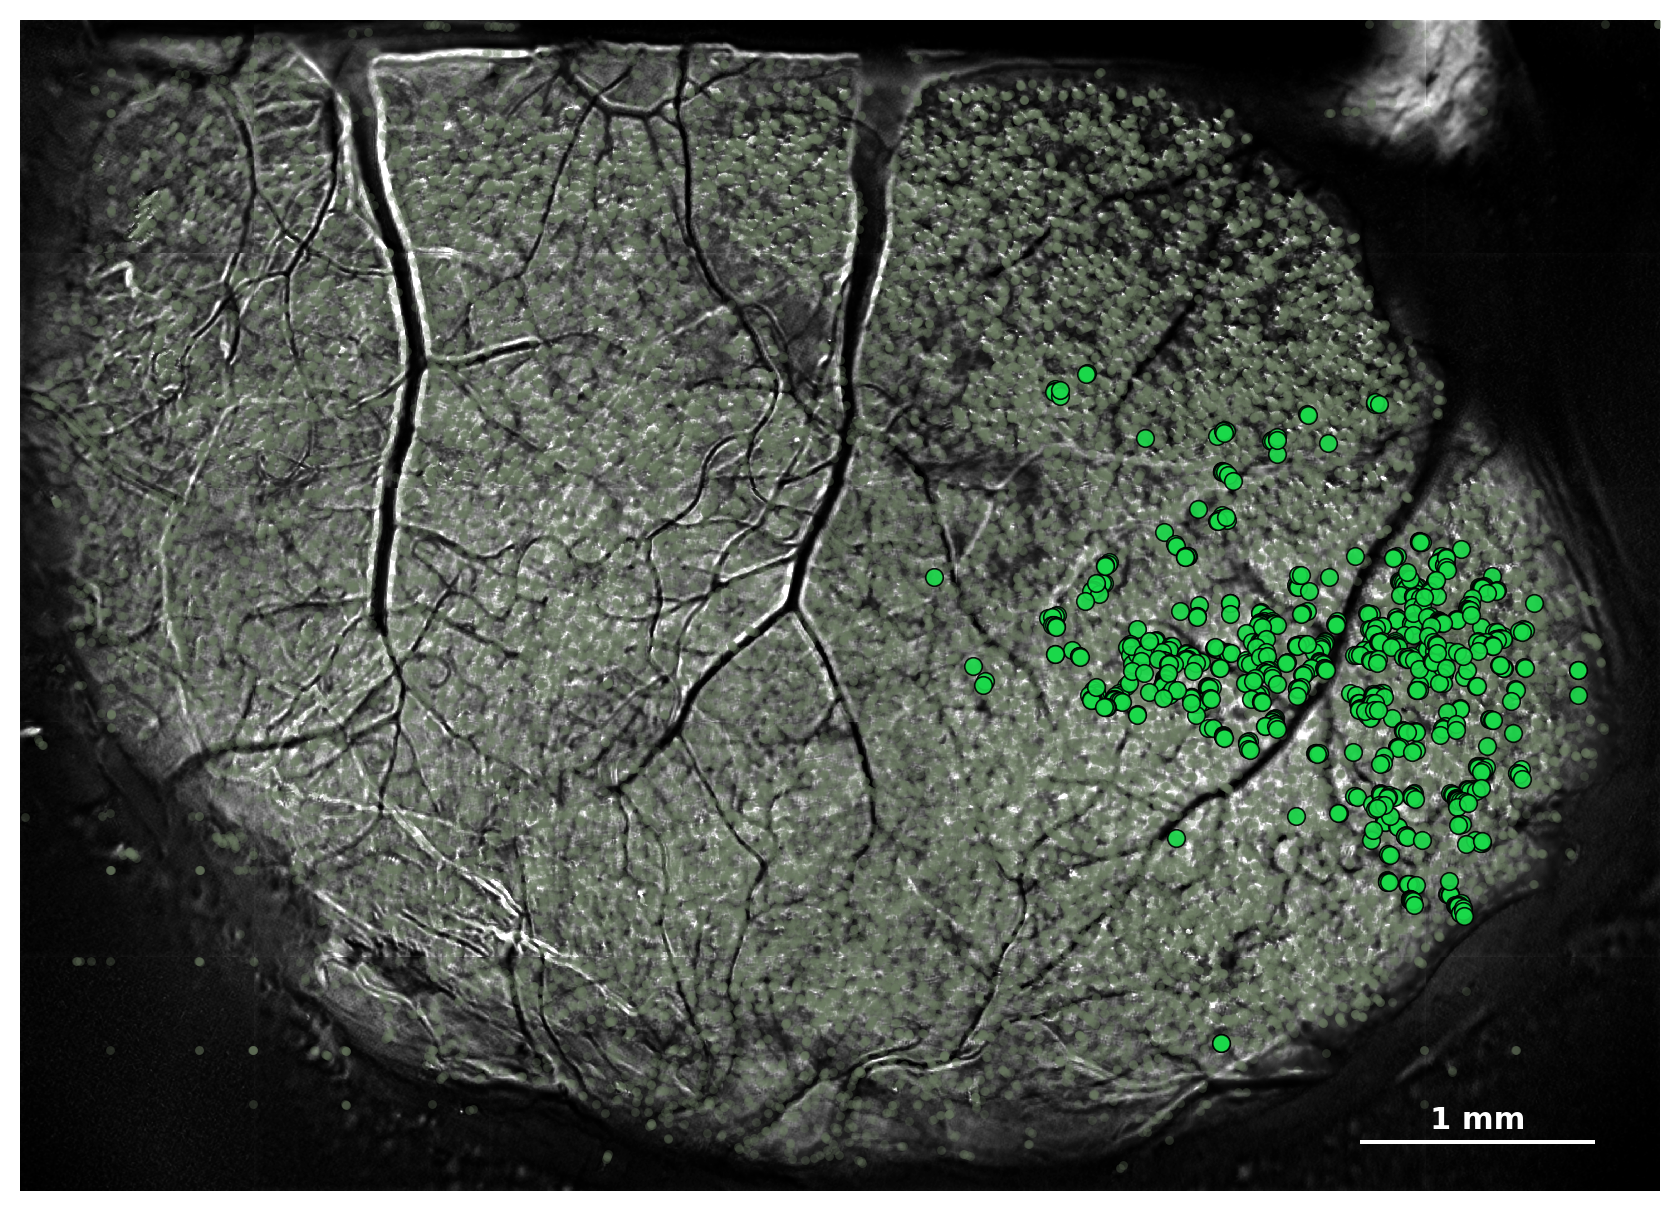

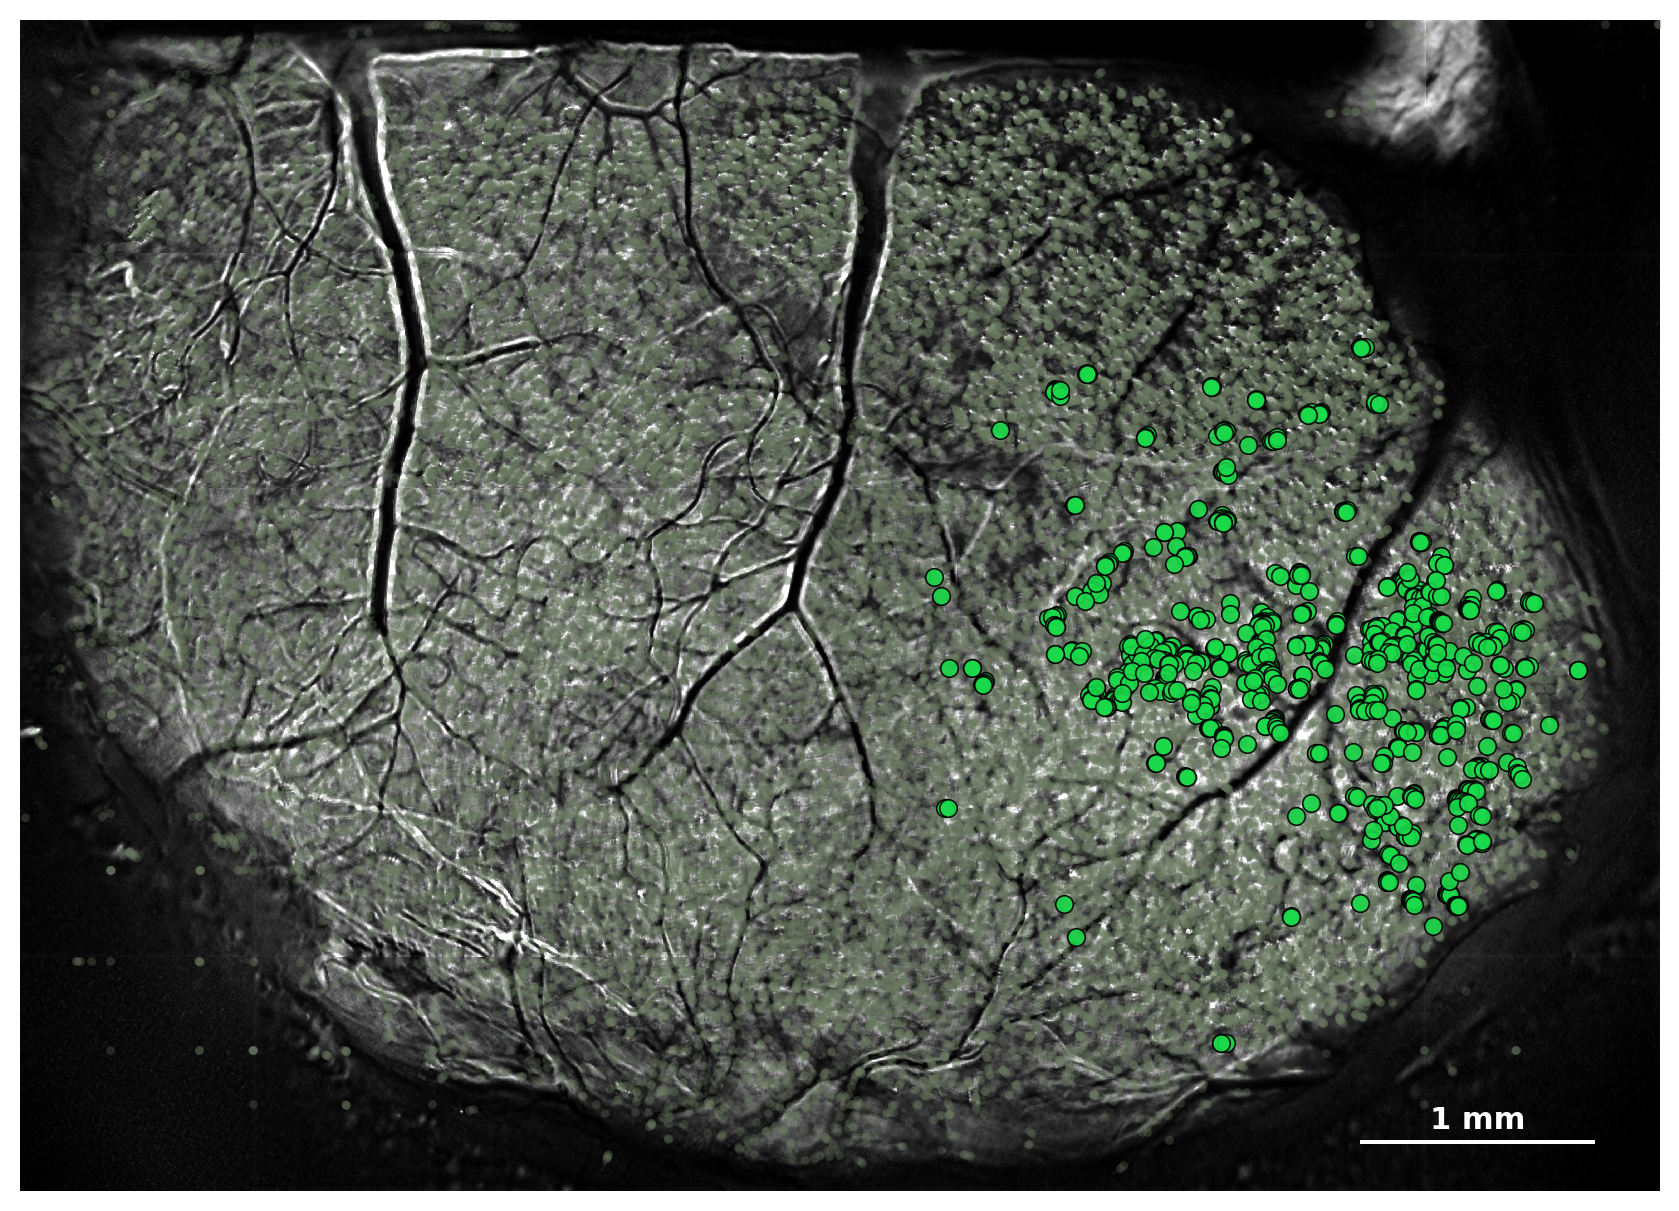

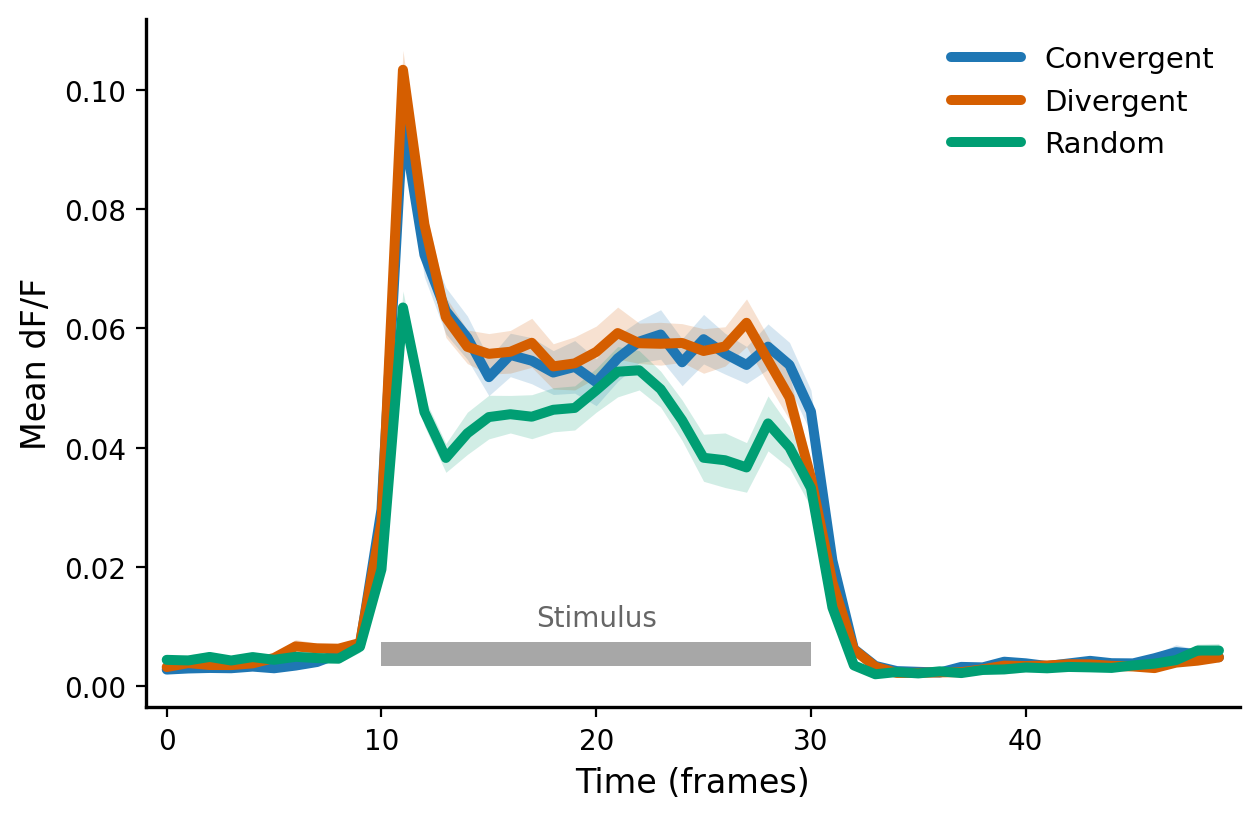

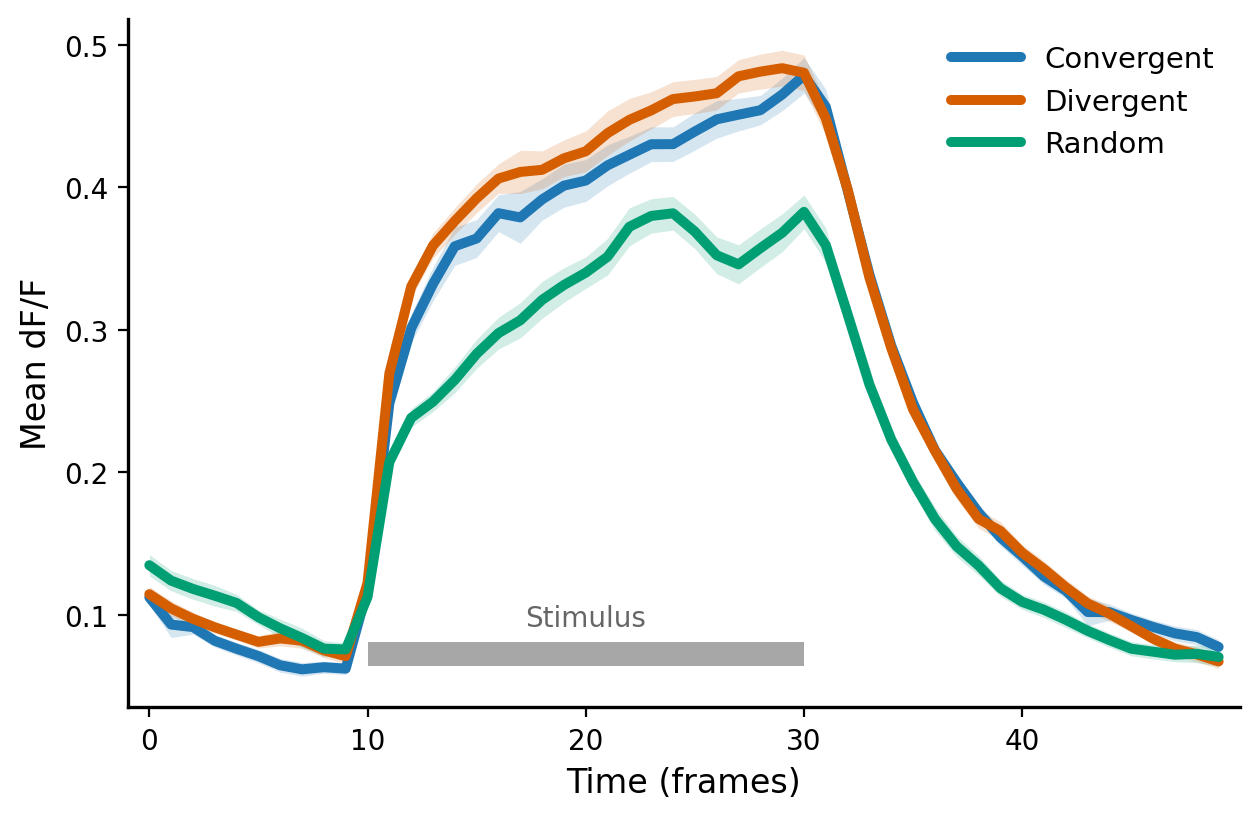

In [ ]:
rr_distribution_plot_pretty(neuron_pos, neuron_pos_spi, data_path, gamma=1.1)
rr_distribution_plot_pretty(neuron_pos, neuron_pos_flo, data_path, gamma=1.1)

# plot_rr_population_average(segments_spi, labels_spi)
# plot_rr_population_average(segments_flo, labels_flo)
plot_rr_population_average_pretty(segments_spi, labels_spi)
plot_rr_population_average_pretty(segments_flo, labels_flo)

In [ ]:
accuracies, time_points, accuracy_std, n_folds = classify_by_timepoints(segments_flo, labels_flo)
labels_shuffled = np.random.permutation(labels_flo)
accuracies_shu, time_points_shu, accuracy_std_shu, n_folds_shu = classify_by_timepoints(segments_flo, labels_shuffled)

fisher_mv, time_points_fi_mv = FI_by_timepoints_v2(segments_flo, 
                                                   labels_flo, 
                                                   mode="multivariate", 
                                                   reduction=None)
fisher_uv, time_points_fi_uv = FI_by_timepoints_v2(segments_flo, labels_flo, mode="univariate", reduction="mean")
neuron_counts, fi_values = FI_by_neuron_count(segments_flo, labels_flo)

In [ ]:
# ============== 编码相关 ==============
def plot_accuracy(
    time_points,
    accuracies,
    accuracy_std=None,
    baseline=None,
    baseline_std=None,
    stim_start=0,
    stim_len=5,
    figsize=(6, 4),
    line_width=3.6,
    acc_color="#1F77B4",      # 美化蓝
    baseline_color="#7A7A7A", # 中性灰
    band_alpha=0.18,
    stim_bar_color="#9E9E9E",
):
    """
    Beautified accuracy plot (scatter-free, paper style)

    Parameters
    ----------
    time_points : array-like
    accuracies : array-like
    accuracy_std : array-like or None
    baseline : array-like or None
        Same shape as accuracies. If None -> do not plot.
    baseline_std : array-like or None
        Same shape as baseline. If None -> no band for baseline.
    stim_start : float/int or None
        Stimulus start time (in same units as time_points)
    stim_len : float/int or None
        Stimulus duration (same units)
    """

    # ---- to numpy ----
    t = np.asarray(time_points)
    acc = np.asarray(accuracies)

    if accuracy_std is not None:
        acc_std = np.asarray(accuracy_std)
    else:
        acc_std = None

    if baseline is not None:
        base = np.asarray(baseline)
        if baseline_std is not None:
            base_std = np.asarray(baseline_std)
        else:
            base_std = None
    else:
        base = None
        base_std = None

    fig, ax = plt.subplots(figsize=figsize, dpi=200)

    # ========= 只保留左/下坐标轴 =========
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", which="both", top=False, right=False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    # ========= 主曲线：Accuracy =========
    if acc_std is not None:
        ax.fill_between(
            t, acc - acc_std, acc + acc_std,
            color=acc_color, alpha=band_alpha, linewidth=0, zorder=1
        )
    ax.plot(
        t, acc,
        color=acc_color, linewidth=line_width,
        solid_capstyle="round",
        label="Accuracy",
        zorder=3
    )

    # ========= baseline（可选） =========
    if base is not None:
        if base_std is not None:
            ax.fill_between(
                t, base - base_std, base + base_std,
                color=baseline_color, alpha=0.12, linewidth=0, zorder=0.9
            )
        ax.plot(
            t, base,
            color=baseline_color, linewidth=line_width-0.8,
            linestyle="-",
            solid_capstyle="round",
            label="Baseline",
            zorder=2
        )

    # ========= 刺激条（可选）：曲线下方灰色横向柱子 =========
    # 放在 y_min 上方一点点，不挡曲线
    if (stim_start is not None) and (stim_len is not None):
        y_min, y_max = ax.get_ylim()
        yr = y_max - y_min
        bar_h = 0.035 * yr
        bar_y = y_min + 0.06 * yr

        ax.broken_barh(
            [(stim_start, stim_len)],
            (bar_y, bar_h),
            facecolors=stim_bar_color,
            edgecolors="none",
            alpha=0.9,
            zorder=0
        )
        ax.text(
            stim_start + stim_len / 2,
            bar_y + bar_h + 0.015 * yr,
            "Stimulus",
            ha="center", va="bottom",
            fontsize=10, color="#666666"
        )

    # ========= 标签/标题 =========
    ax.set_xlabel("Time(s)", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    # ax.set_title("Classification Accuracy Over Time", fontsize=13.5, weight="bold", pad=10)

    # ========= Legend（更干净） =========
    ax.legend(frameon=False, fontsize=10.5, loc="upper right", handlelength=2.4)

    # 不要网格（更论文风）；如果你想要淡网格可以打开下面两行
    # ax.grid(True, axis="y", alpha=0.15, linewidth=0.8)
    # ax.grid(False, axis="x")

    ax.margins(x=0.02)
    fig.tight_layout()
    plt.show()
def plot_fisher_information(
    time_points,
    fisher,
    stim_start=0,
    stim_len=5,
    figsize=(6, 4),
    line_width=3.6,
    # 你可以按喜好调整下面三种颜色
    colors=None
):
    """
    Fisher information over time (beautified, paper style)

    fisher: dict
        keys are pairs like (1,2), (1,3), (2,3)
        values are arrays aligned with time_points
    """

    # ===== 类别名字定义 =====
    CLASS_NAMES = {
        1: "Convergent",
        2: "Divergent",
        3: "Random"
    }

    # ===== 颜色策略 =====
    # 让 (1,2)（Convergent vs Divergent）更“轻”一点（差异小），
    # 另外两条更醒目、更区分开
    if colors is None:
        colors = {
            (1, 2): "#9BB7D4",  # 浅蓝（弱强调）
            (1, 3): "#4E79A7",  # 橙红（强区分）
            (2, 3): "#1F4E79",  # 绿（强区分）
        }

    def _norm_pair(k):
        """把 (np.int64(1), np.int64(2)) 之类转成 (1,2)，并排序"""
        a, b = int(k[0]), int(k[1])
        return tuple(sorted((a, b)))

    t = np.asarray(time_points)

    fig, ax = plt.subplots(figsize=figsize, dpi=200)

    # ===== 坐标轴风格：只保留左/下 =====
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", which="both", top=False, right=False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    # ===== 画线 =====
    # 为了 legend 顺序稳定，按 (1,2),(1,3),(2,3) 的顺序画
    preferred_order = [(1, 2), (1, 3), (2, 3)]

    # 先把 fisher 规范化成 { (a,b): arr }
    fisher_norm = {}
    for k, v in fisher.items():
        fisher_norm[_norm_pair(k)] = np.asarray(v)

    for pair in preferred_order:
        if pair not in fisher_norm:
            continue

        a, b = pair
        label = f"{CLASS_NAMES[a]} vs {CLASS_NAMES[b]}"
        color = colors.get(pair, "#333333")

        # (1,2) 这条差异小：可以稍微细一点或更透明一点（你也可反过来更突出）
        lw = line_width - 0.4 if pair == (1, 2) else line_width
        alpha = 0.95 if pair == (1, 2) else 0.98

        ax.plot(
            t, fisher_norm[pair],
            color=color, linewidth=lw,
            solid_capstyle="round",
            label=label,
            alpha=alpha,
            zorder=3 if pair != (1, 2) else 2
        )

    # ===== 刺激条（曲线下方灰色横向柱子） =====
    if (stim_start is not None) and (stim_len is not None):
        y_min, y_max = ax.get_ylim()
        yr = y_max - y_min
        bar_h = 0.035 * yr
        bar_y = y_min + 0.02 * yr

        ax.broken_barh(
            [(stim_start, stim_len)],
            (bar_y, bar_h),
            facecolors="#9E9E9E",
            edgecolors="none",
            alpha=0.9,
            zorder=0
        )
        ax.text(
            stim_start + stim_len / 2,
            bar_y + bar_h + 0.015 * yr,
            "Stimulus",
            ha="center", va="bottom",
            fontsize=10, color="#666666"
        )

    # ===== 标题/标签 =====
    ax.set_xlabel("Time(s)", fontsize=12)
    ax.set_ylabel("Fisher Information", fontsize=12)
    # ax.set_title("Fisher Information Over Time", fontsize=13.5, weight="bold", pad=10)

    # 不画大网格（更论文风）；如果你想保留淡淡的 y 网格可打开下面两行
    # ax.grid(True, axis="y", alpha=0.15, linewidth=0.8)
    # ax.grid(False, axis="x")

    ax.legend(frameon=False, fontsize=10.5, loc="upper right", handlelength=2.4)

    ax.margins(x=0.02)
    fig.tight_layout()
    plt.show()


def plot_fi_by_neuron_count(
    neuron_counts,
    fi_values,
    figsize=(6, 4),
    line_width=3.2,
    marker_size=22,
    color="#1F4E79"   # 深蓝，同 Fisher 信息主色
):
    """
    Fisher Information vs Neuron Count (paper-style)
    """

    x = np.asarray(neuron_counts)
    y = np.asarray(fi_values)

    fig, ax = plt.subplots(figsize=figsize, dpi=200)

    # ===== 坐标轴：只保留左 / 下 =====
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", which="both", top=False, right=False)
    ax.spines["left"].set_linewidth(1.2)
    ax.spines["bottom"].set_linewidth(1.2)

    # ===== 主曲线 =====
    ax.plot(
        x, y,
        color=color,
        linewidth=line_width,
        solid_capstyle="round",
        zorder=2
    )

    # ===== 散点（作为强调，不喧宾夺主） =====
    # ax.scatter(
    #     x, y,
    #     s=marker_size,
    #     facecolor=color,
    #     edgecolor="white",
    #     linewidth=0.6,
    #     alpha=0.9,
    #     zorder=3
    # )

    # ===== 标签 / 标题 =====
    ax.set_xlabel("Number of Neurons", fontsize=12)
    ax.set_ylabel("Fisher Information", fontsize=12)
    # ax.set_title(
    #     "Fisher Information vs Neuron Count",
    #     fontsize=13.5, weight="bold", pad=10
    # )

    # ===== 网格：只保留非常淡的 y 网格（可选） =====
    ax.grid(True, axis="y", alpha=0.15, linewidth=0.8)
    ax.grid(False, axis="x")

    ax.margins(x=0.02)
    fig.tight_layout()
    plt.show()

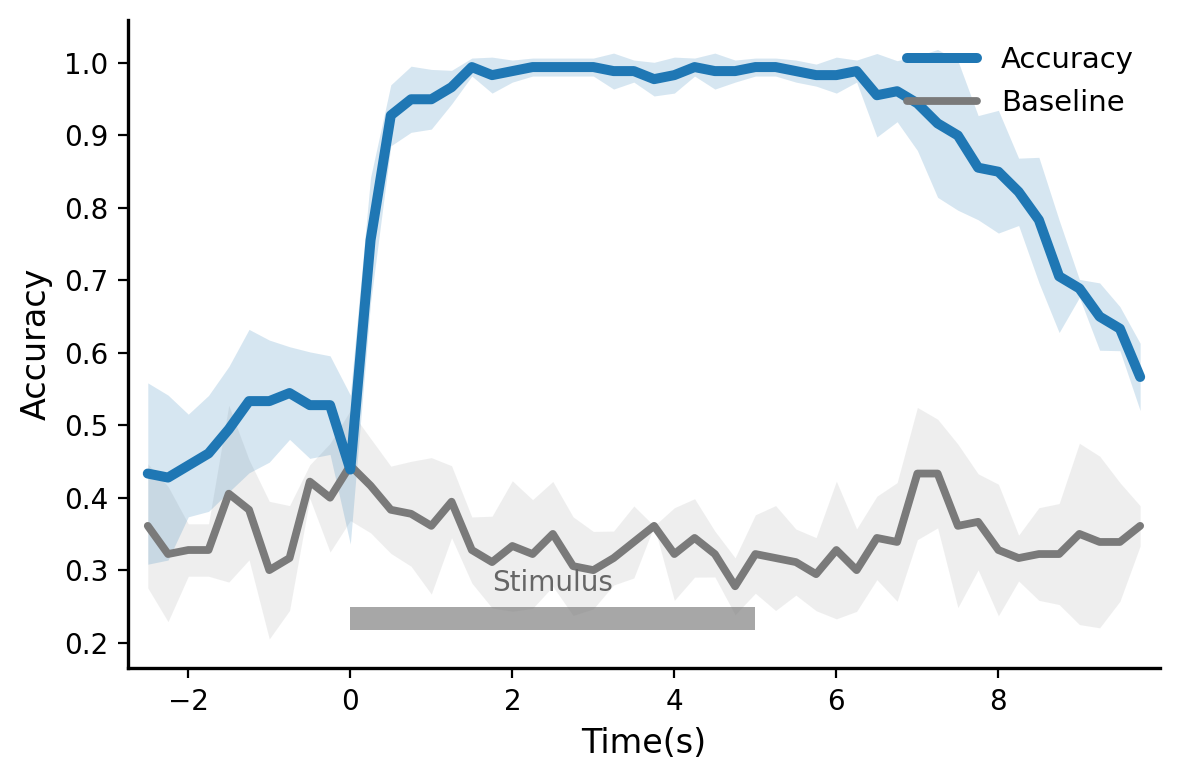

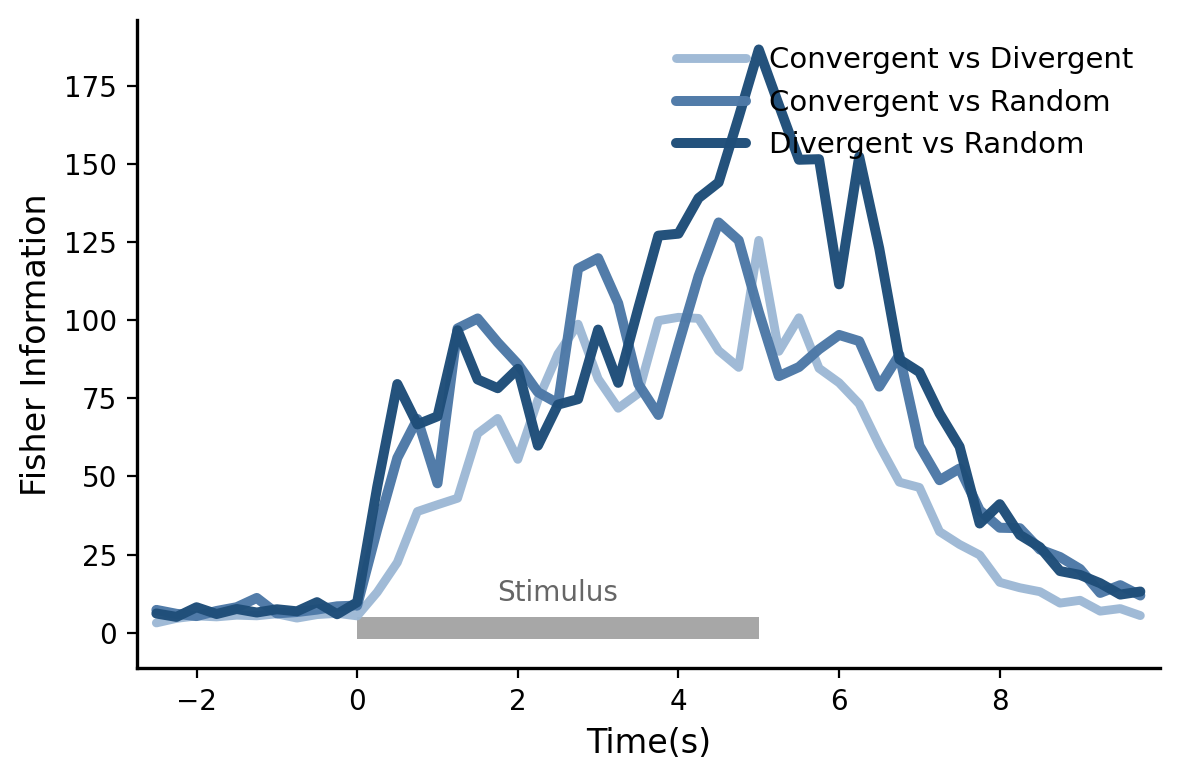

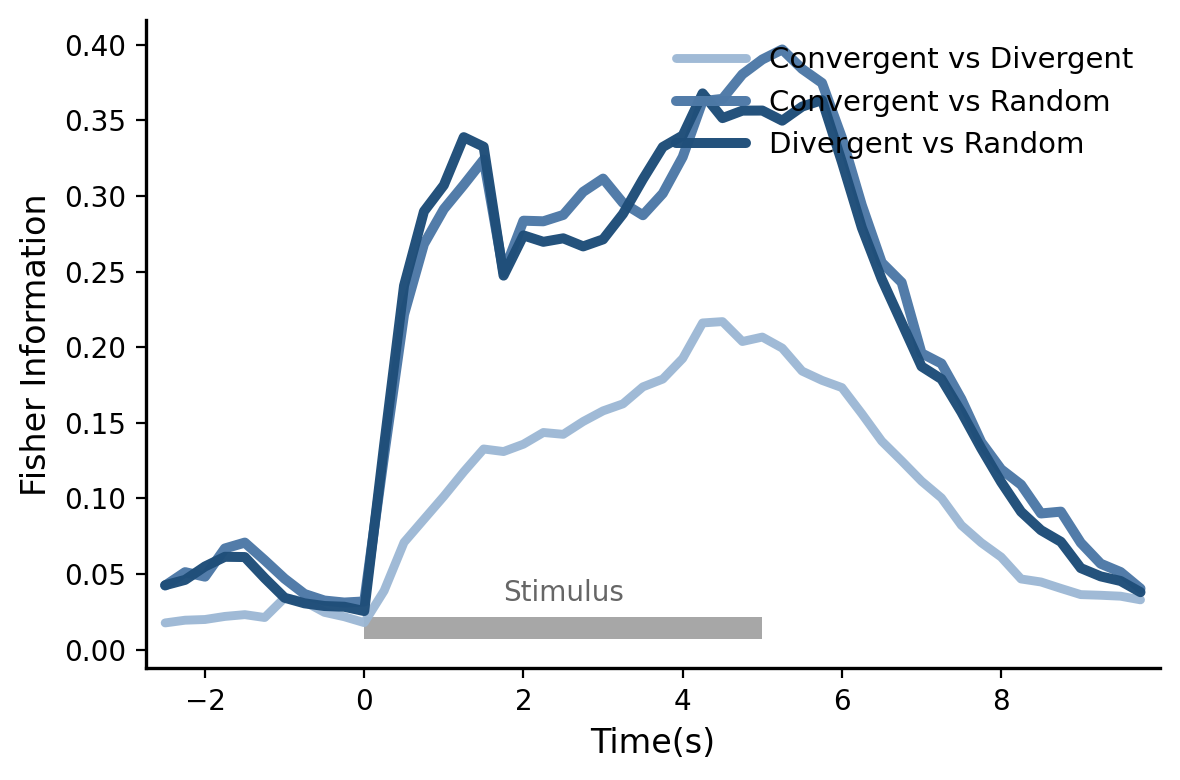

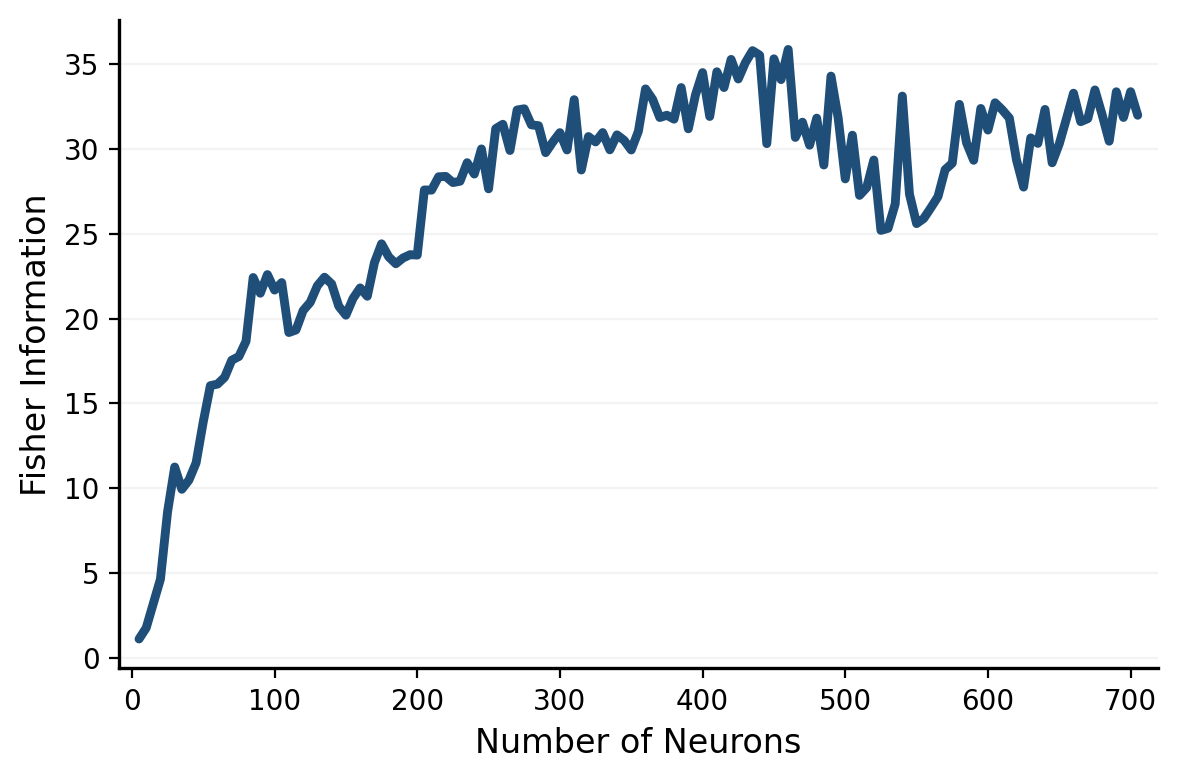

In [ ]:
plot_accuracy(time_points, accuracies, accuracy_std,  baseline=accuracies_shu, baseline_std=accuracy_std_shu)
plot_fisher_information(time_points_fi_mv, fisher_mv)
plot_fisher_information(time_points_fi_uv, fisher_uv)
plot_fi_by_neuron_count(neuron_counts, fi_values)

In [ ]:
nx_result = compute_network_metrics_by_class(segments_spi, labels_spi, neuron_pos_spi, do_bootstrap=False)

In [ ]:
nx_result

{np.int64(1): {'corr_matrix': array([[1.        , 0.22141029, 0.81468733, ..., 0.2079573 , 0.18953929,
          0.18708794],
         [0.22141029, 1.        , 0.21921608, ..., 0.20126037, 0.15240538,
          0.16345531],
         [0.81468733, 0.21921608, 1.        , ..., 0.18499039, 0.14671499,
          0.14406614],
         ...,
         [0.2079573 , 0.20126037, 0.18499039, ..., 1.        , 0.79318696,
          0.82318283],
         [0.18953929, 0.15240538, 0.14671499, ..., 0.79318696, 1.        ,
          0.887386  ],
         [0.18708794, 0.16345531, 0.14406614, ..., 0.82318283, 0.887386  ,
          1.        ]], shape=(754, 754)),
  'corr_graph': <networkx.classes.graph.Graph at 0x1ee000ebe00>,
  'summary': {'n_nodes': 754,
   'n_edges': 14194,
   'density': 0.04999982386986096,
   'mean_degree': 37.649867374005304,
   'largest_component': 684,
   'avg_clustering': 0.6439459432629132,
   'global_efficiency': 0.34571226273459726,
   'local_efficiency': 0.7846342587976022,
   

In [ ]:
# 绘制相关矩阵分布的小提琴图
import matplotlib.pyplot as plt
import numpy as np

# 类名定义
CLASS_NAMES = {1: "Convergent", 2: "Divergent", 3: "Random"}
CLASS_COLORS = {
    1: "#1F77B4",  # 蓝
    2: "#D55E00",  # 橙红
    3: "#009E73",  # 绿
}

# 提取每个类别的相关系数（排除对角线）
corr_data = []
class_labels = []
class_order = [1, 2, 3]

for cls in class_order:
    if cls in nx_result:
        corr_matrix = nx_result[cls]['corr_matrix']
        # 获取上三角的相关系数（排除对角线）
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
        corr_values = corr_matrix[mask]
        corr_data.append(corr_values)
        class_labels.append(CLASS_NAMES[cls])

# 绘制小提琴图
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=200)

# 创建小提琴图
parts = ax.violinplot(
    corr_data,
    positions=range(len(class_order)),
    widths=0.7,
    showmeans=True,
    showmedians=True,
)

# 为每个小提琴设置颜色
for i, pc in enumerate(parts['bodies']):
    cls = class_order[i]
    pc.set_facecolor(CLASS_COLORS[cls])
    pc.set_alpha(0.7)
    pc.set_edgecolor(CLASS_COLORS[cls])
    pc.set_linewidth(1.2)

# 设置其他线条的样式
for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
    if partname in parts:
        vp = parts[partname]
        vp.set_edgecolor('#333333')
        vp.set_linewidth(1.2)

# 坐标轴美化
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)

# 设置 x 轴标签
ax.set_xticks(range(len(class_order)))
ax.set_xticklabels(class_labels, fontsize=11)

# 标签和标题
ax.set_ylabel('Correlation Coefficient', fontsize=12)
ax.set_xlabel('Stimulus Type', fontsize=12)
# ax.set_title('Distribution of Pairwise Correlations', fontsize=13.5, weight='bold', pad=10)

# 添加水平参考线
ax.axhline(y=0, color='#888888', linestyle='--', linewidth=0.8, alpha=0.5, zorder=0)

fig.tight_layout()
plt.show()